In [77]:
!pip install blackjax

Import the required libraries.

In [ ]:
import jax.scipy.stats as stats
import jax.random as random
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
import blackjax

key = jax.random.PRNGKey(70)

Funtions for generating the synthetic dataset.

`noise(size,variance)` funtion generates guassian noise with mean=0 and given variance.

`f(X, noise_variance)` gives a Linear funtion with noise.

`g(X, noise_variance)` Sinusoidial function plus noise



In [79]:
# change the parameters of linear funtion here.
f_w0 = 10
f_w1 =  2

def noise(size, variance):
    global key
    key, subkey = jax.random.split(key)
    noise = jax.random.normal(key, shape=size)*jnp.sqrt(variance)
    return noise

def f(X, noise_variance):
    '''Linear function plus noise'''
    t = f_w0 + f_w1 * X + noise(X.shape, noise_variance)
    return t

def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + jnp.sin(2 * jnp.pi * X) + noise(X.shape, noise_variance)


This block of code helps us to get design matrix `Φ(X)` with given `X` and given basis funtion `bf`

In [80]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return jnp.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return jnp.concatenate([jnp.ones(x.shape), bf(x)], axis=1)
    else:
        return jnp.concatenate([jnp.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

The following funtions are for plotting the results and given data.

In [81]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    # fill between 2 standard deviations around the mean as specified.
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = jnp.linspace(1, 19, resolution)
    grid_flat = jnp.dstack(jnp.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(0, 20, 0, 20))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()


## Using the analytical solutions for mean and variance of posterior distribution

As noted in 'Pattern recognition and machine learning by Bishop in section 3.3(pg no. 153) if we consider a gaussian prior for the parameters and assume that the noise parameter beta is known to us, then we can find the analytical solution for the mean and variance of the posterior comes out to be 

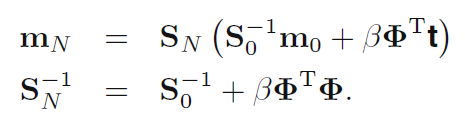

The funtion `posterior(Phi, t, alpha, beta, return_inverse=False)` calculates the same.


`posterior_predictive(Phi_test, m_N, S_N, beta)` Computes mean and variances of the posterior predictive distribution.
The predictive distribution is given by:

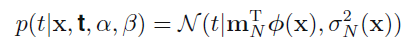

with variance:

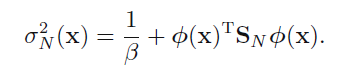


In [78]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * jnp.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = jnp.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + jnp.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    return y, y_var




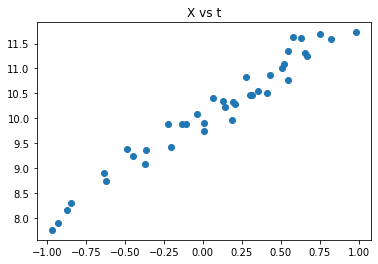

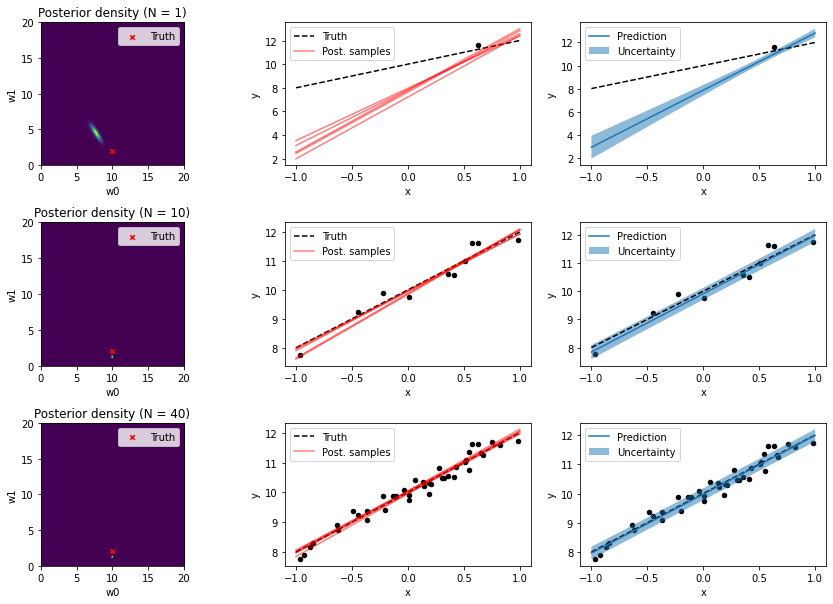

In [98]:
# Training dataset sizes
N_list = [1, 10, 40]

beta = 25
alpha = 2.0

# Training observations in [-1, 1)

X = jax.random.uniform(key,shape=(N_list[-1], 1)) * 2 - 1
key, subkey = jax.random.split(key)
# Training target values
t = f(X, noise_variance=1/beta)

plt.scatter(X,t)
plt.title("X vs t")
plt.show()
print()
# Test observations
X_test = jnp.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    key, subkey = jax.random.split(key)
    w_samples = jax.random.multivariate_normal(key,m_N.ravel(), S_N, shape=(5,)).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    # plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, jnp.sqrt(y_var))
    # plt.ylim(-1.5, 1.0)
    plt.legend()

From the above figures we can infer that as the No of samples increases we are getting lesser error in our predication and the value is converging to the truth value of the given data.

# Using sampling from BlackJAX to infer the mean and variance of the Posterior.

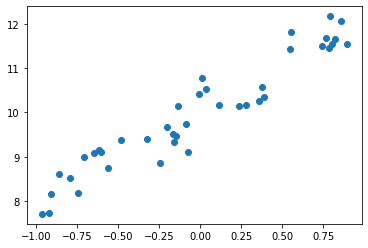

In [162]:
key = jax.random.PRNGKey(70)
X = jax.random.uniform(key,shape=(N_list[-1], 1)) * 2 - 1
# Training target values
beta = 5
t = f(X, noise_variance=1/beta)
Phi = expand(X,identity_basis_function)
plt.scatter(X,t)
plt.show()

The random walk rmh sampler takes log of the probability funtion as the input. 

The log of the posterior distribution is given by the sum of log likelihood and the log of the prior and as a funtion of **w** takes the form

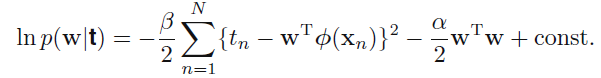





In [163]:
def logprob_fn(W):
  W = W.reshape(W.shape[0],1)
  prior = -alpha* W.T@W
  likelihood = (-beta/2)*(t - Phi@W).T @ (t - Phi@W)
  return (prior + likelihood)[0,0]

rng_key = random.PRNGKey(314)
N, M = Phi.shape
w0 = random.multivariate_normal(rng_key, 0.1 + jnp.zeros(M), jnp.eye(M))
rmh = blackjax.rmh(logprob_fn, sigma=jnp.ones(M) * 0.7)
initial_state = rmh.init(w0)

Since blackjax does not provide an inference loop we need to implement one ourselves:

source: [Blackjax documentation](https://blackjax-devs.github.io/blackjax/examples/LogisticRegression.html) 

In [164]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [165]:
_, rng_key = random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 5_000)

We can see that over the first 100 or so iterations the values change significantly before going to some constant values, which are the true values from the synthetic data. It is convention to define a ‘burn-in’ period where we assume the parameters are still converging . Therefore, we can define a new array that contains the final 500 iterations called trace_burnt, and plot histograms of the values:


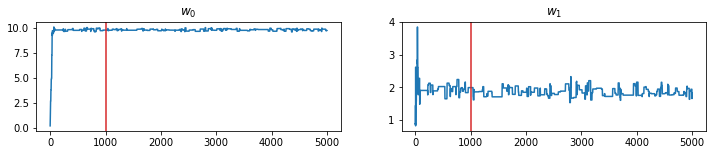

In [166]:
burnin = 1000
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

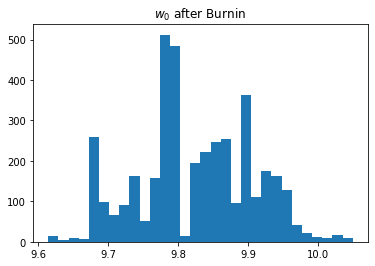

In [167]:
trace_burnt = states.position[burnin:]
# print(trace_burnt)
plt.hist(trace_burnt[:,0],bins=30)
plt.title(f"$w_0$ after Burnin")
plt.show()
# hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

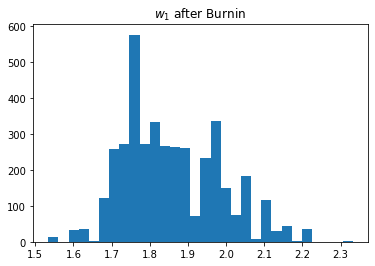

In [168]:
plt.hist(trace_burnt[:,1],bins = 30)
plt.title("$w_1$ after Burnin")
plt.show()

We take the mean and covariance of the parameters as the mean and covariance of the samples.


In [169]:
m_N = jnp.mean(trace_burnt,axis=0)
S_N = jnp.cov(trace_burnt.T)


Now plot the results.

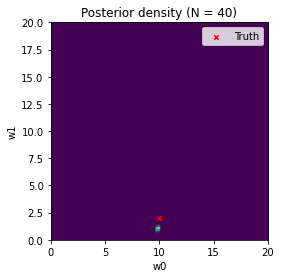

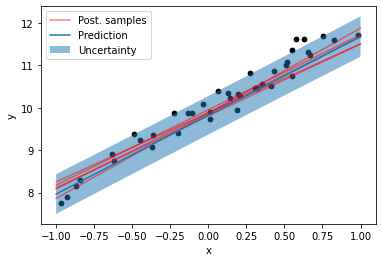

In [171]:
X_test = jnp.linspace(-1,1,1000)
X_test = X_test.reshape(-1,1)
Phi_test = expand(X_test,identity_basis_function)
y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
# Draw 5 random weight samples from posterior and compute y values
w_samples = jax.random.multivariate_normal(key,m_N.ravel(), S_N, shape=(5,)).T
y_samples = Phi_test.dot(w_samples)


i = 0
# plt.subplot(len(N_list), 3, i * 3 + 1)
plot_posterior(m_N, S_N, f_w0, f_w1)
plt.title(f'Posterior density (N = {N})')
plt.legend()
plt.show()
print()
# plt.subplot(len(N_list), 3, i * 3 + 2)
plot_data(X_N, t_N)
# plot_truth(X_test, y_true)
plot_posterior_samples(X_test, y_samples)
# plt.ylim(-1.5, 1.0)
plt.legend()

# plt.subplot(len(N_list), 3, i * 3 + 3)
plot_data(X_N, t_N)
# plot_truth(X_test, y_true, label=None)
plot_predictive(X_test, y, jnp.sqrt(y_var))
plt.plot()
# plt.ylim(-1.5, 1.0)
plt.legend()
plt.show()